In [977]:
import git
repo = git.Repo("./", search_parent_directories=True)

In [798]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Data Preparation

Directory

In [3]:
homedir = repo.working_dir
datadir = f"{homedir}/data/"

## international/health

Let's take a look at the health data from the international folder.

In [4]:
import pandas as pd
df = pd.read_csv(datadir + 'international/health/hospital-beds-per-1000-people.csv')

We can pivot it using countries and years:

In [5]:
df=df.dropna(subset=['Code'])

In [6]:
X_beds=df.pivot(index="Code",columns="Year",values="Hospital beds (per 1,000 people) (per 1,000 people)")
X_beds.head()

Year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Code,,,,,,,,,,,,,,,,,,,,,
AFG,0.170627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.42,0.42,0.4,0.4,NaN,0.5,NaN,NaN
AGO,2.061462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,5.102676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.00,2.9692,2.90,NaN,2.8,NaN,2.43,2.6,NaN,NaN
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.70,2.6000,2.60,NaN,2.5,NaN,NaN,NaN,NaN,NaN
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.88,NaN,1.86,1.90,NaN,NaN,NaN,1.1,NaN,NaN


Notice that all the records are earlier than 2014, so for inference purpose we can only resort to the last non-NaN column for each country, and assume that it hasn't significantly changed since then.

In [7]:
ind = {x:X_beds.loc[x].last_valid_index() for x in X_beds.index}
last_data_point_beds_per_mille = {x:X_beds.loc[x, ind[x]] for x in X_beds.index}

Actually, we can build a helper function to do this:

In [8]:
def to_last_record(X):
    ind = {x:X.loc[x].last_valid_index() for x in X.index}
    return pd.Series([X.loc[x, ind[x]] for x in X.index], index=X.index)

In [9]:
df_phys = pd.read_csv(datadir + 'international/health/physicians-per-1000-people.csv')
df_phys.head()

,Entity,Code,Year,"Physicians (per 1,000 people) (per 1,000 people)"
0,Afghanistan,AFG,1960,0.035
1,Afghanistan,AFG,1965,0.063
2,Afghanistan,AFG,1970,0.065
3,Afghanistan,AFG,1981,0.077
4,Afghanistan,AFG,1986,0.183


In [10]:
X_phys = df_phys.pivot(index="Entity",columns="Year",values="Physicians (per 1,000 people) (per 1,000 people)")

In [11]:
df_pneu = pd.read_csv(datadir + 'international/health/pneumonia-death-rates-age-standardized.csv')
df_pneu.head()

,Entity,Code,Year,Deaths - Lower respiratory infections - Sex: Both - Age: Age-standardized (Rate) (Rate)
0,Afghanistan,AFG,1990,164.811829
1,Afghanistan,AFG,1991,151.460290
2,Afghanistan,AFG,1992,127.896225
3,Afghanistan,AFG,1993,124.725141
4,Afghanistan,AFG,1994,134.410918


In [12]:
X_pneu = df_pneu.pivot(index="Entity",columns="Year",values="Deaths - Lower respiratory infections - Sex: Both - Age: Age-standardized (Rate) (Rate)")

In [13]:
df_heart = pd.read_csv(datadir + 'international/health/share-deaths-heart-disease.csv')
df_heart.head()

,Entity,Code,Year,Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Percent) (%)
0,Afghanistan,AFG,1990,23.707752
1,Afghanistan,AFG,1991,23.490307
2,Afghanistan,AFG,1992,23.146918
3,Afghanistan,AFG,1993,21.154207
4,Afghanistan,AFG,1994,19.756144


In [14]:
X_heart = df_heart.pivot(index="Entity",columns="Year",values="Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Percent) (%)")

In [15]:
df_smoke = pd.read_csv(datadir + 'international/health/share-of-adults-who-smoke.csv')
df_smoke.head()

,Entity,Code,Year,"Smoking prevalence, total (ages 15+) (% of adults)"
0,Albania,ALB,2000,34.8
1,Albania,ALB,2005,32.7
2,Albania,ALB,2010,31.2
3,Albania,ALB,2011,30.7
4,Albania,ALB,2012,30.2


In [16]:
X_smoke = df_smoke.pivot(index="Entity",columns="Year",values="Smoking prevalence, total (ages 15+) (% of adults)")

We should also take a look at which years are polled:

In [17]:
from collections import Counter
for data in [X_beds, X_phys, X_pneu, X_heart, X_smoke]:
    print("")
    print(Counter([data.loc[x].last_valid_index() for x in data.index]))


Counter({2011: 83, 2012: 68, 2010: 28, 1990: 13, 2009: 12, 2005: 11, 2006: 11, 1996: 4, 2004: 2, 1970: 2, 2007: 2, 2008: 2, 1981: 1, 2014: 1, 1985: 1, 2013: 1, 1960: 1, 1997: 1, 2001: 1})

Counter({2013: 59, 2014: 48, 2015: 43, 2010: 27, 2016: 21, 2012: 10, 2009: 7, 2011: 7, 2004: 7, 1999: 5, 2001: 5, 1995: 4, 1997: 2, 1981: 1, 2000: 1, 1980: 1, 2006: 1, 1998: 1, 2005: 1, 2003: 1, 1987: 1})

Counter({2017: 231})

Counter({2017: 231})

Counter({2016: 186, 2014: 1})


The last three looks good, but the first two data contain results from a long span of time. This means some data can be quite inaccurate if used for inference. We can try to extrapolate, but let's leave that to the future.

In [18]:
import pygal.maps

In [70]:
last_data_point_beds_per_mille

{'AFG': 0.5,
 'AGO': 0.8,
 'ALB': 2.6,
 'AND': 2.5,
 'ARE': 1.1,
 'ARG': 4.7,
 'ARM': 3.9,
 'ATG': 2.1,
 'AUS': 3.9,
 'AUT': 7.6,
 'AZE': 4.7,
 'BDI': 1.9,
 'BEL': 6.5,
 'BEN': 0.5,
 'BFA': 0.4,
 'BGD': 0.6,
 'BGR': 6.4,
 'BHR': 2.1,
 'BHS': 2.9,
 'BIH': 3.5,
 'BLR': 11.3,
 'BLZ': 1.1,
 'BMU': 6.3000001907000005,
 'BOL': 1.1,
 'BRA': 2.3,
 'BRB': 6.2,
 'BRN': 2.8,
 'BTN': 1.8,
 'BWA': 1.8,
 'CAF': 1.0,
 'CAN': 2.7,
 'CHE': 5.0,
 'CHL': 2.1,
 'CHN': 3.8,
 'CIV': 0.4,
 'CMR': 1.3,
 'COD': 0.8,
 'COG': 1.6,
 'COL': 1.5,
 'COM': 2.2,
 'CPV': 2.1,
 'CRI': 1.2,
 'CUB': 5.3,
 'CYM': 3.0,
 'CYP': 3.5,
 'CZE': 6.8,
 'DEU': 8.2,
 'DJI': 1.4,
 'DMA': 3.8,
 'DNK': 3.5,
 'DOM': 1.7,
 'DZA': 1.7,
 'ECU': 1.6,
 'EGY': 0.5,
 'ERI': 0.7,
 'ESP': 3.1,
 'EST': 5.3,
 'ETH': 6.3,
 'FIN': 5.5,
 'FJI': 2.1,
 'FRA': 6.4,
 'FSM': 3.2,
 'GAB': 6.3,
 'GBR': 2.9,
 'GEO': 2.6,
 'GHA': 0.9,
 'GIN': 0.3,
 'GMB': 1.1,
 'GNB': 1.0,
 'GNQ': 2.1,
 'GRC': 4.8,
 'GRD': 3.5,
 'GRL': 14.353400230407699,
 'GTM': 0.6,
 'GUY':

In [88]:
min(last_data_point_beds_per_mille.values())

0.1

In [89]:
import numpy as np

In [94]:
import pycountry
maps = {}
for keys in last_data_point_beds_per_mille.keys():
    tmp = pycountry.countries.get(alpha_3=keys)
    try:
        maps[tmp.alpha_2.lower()] = (last_data_point_beds_per_mille[keys])
    except:
        pass

In [98]:
worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = 'Beds per mille'
worldmap_chart.add('Latest available', maps)
worldmap_chart.render_to_png('worldbeds.png')

### Correlations

In [61]:
df_total = pd.DataFrame()
df_total['beds'] = to_last_record(X_beds)
df_total['phys'] = to_last_record(X_phys)
df_total['pneu'] = to_last_record(X_pneu)
df_total['heart'] = to_last_record(X_heart)
df_total['smoke'] = to_last_record(X_smoke)

In [65]:
df_total.head()

,beds,phys,pneu,heart,smoke
Entity,,,,,
Afghanistan,0.5,0.295,69.130715,24.780577,NaN
Albania,2.6,1.286,12.152588,55.822085,28.7
Algeria,1.7,1.207,15.524824,47.284557,15.6
Andorra,2.5,3.690,18.121082,30.647196,33.5
Angola,0.8,0.144,92.216442,11.828254,NaN


Note that some entries are invalid. This is because the original dataset might not contain some countries at all.

Given the data we have for each country, let us plot the correlation matrix:

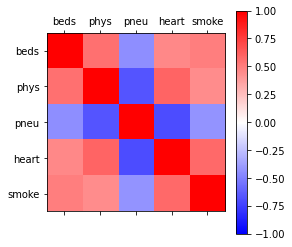

In [97]:
import matplotlib.pyplot as plt

plt.matshow(df_total.corr(), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks(range(df_total.shape[1]), df_total.columns)
plt.yticks(range(df_total.shape[1]), df_total.columns)
plt.show()

## Covid-19 cases

In [99]:
df_covid=pd.read_csv(datadir+'international/covid/our_world_in_data/full_data.csv')
df_covid.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0


In [100]:
Y_d=df_covid.pivot(index="location",columns="date",values="total_deaths")
Y_i=df_covid.pivot(index="location",columns="date",values="total_cases")

Let's see the top 100 countries with the most confirmed cases:

In [101]:
Y_i.sort_values(by='2020-04-14').iloc[-100:-1]

date,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,...,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14
location,,,,,,,,,,,,,,,,,,,,,
Malta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0,234.0,241.0,293.0,299.0,337.0,350.0,370.0,378.0,384.0
Jordan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,323.0,345.0,349.0,349.0,358.0,372.0,372.0,381.0,389.0,391.0
Taiwan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,363.0,363.0,373.0,376.0,379.0,380.0,380.0,385.0,388.0,393.0
Honduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,268.0,298.0,305.0,312.0,343.0,382.0,392.0,393.0,397.0,407.0
Kyrgyzstan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,144.0,216.0,228.0,270.0,280.0,298.0,339.0,377.0,419.0,430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91714.0,95391.0,99225.0,103228.0,108202.0,113525.0,117658.0,120479.0,123016.0,125098.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124632.0,128948.0,132547.0,135586.0,139422.0,143626.0,147577.0,152271.0,156363.0,159516.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124736.0,130759.0,135032.0,140510.0,146690.0,152446.0,157022.0,161852.0,166019.0,169496.0


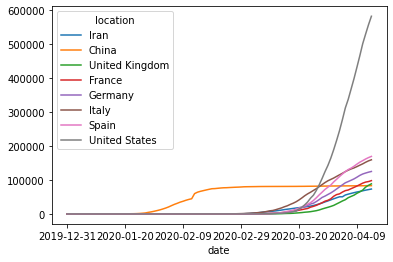

In [99]:
Y_i.sort_values(by='2020-04-14').iloc[-10:-2].T.plot()

# SEIR

## Fitting parameters

In [1298]:
df_pop = pd.read_csv(datadir + 'us/demographics/county_populations.csv')

In [1322]:
def diff(dat, t,params):
    beta = params[0]
    delta = params[1]
    gamma = params[2]
    alpha = params[3]
    lambda_ = params[4]
    kappa = params[5]
    
    s = dat[0]
    e = dat[1]
    i = dat[2]
    q = dat[3]
    r = dat[4]
    d = dat[5]
    sa = dat[6]
    
    dsdt = - beta * s * i - alpha * s
    dedt = beta * s * i - gamma * e
    didt = gamma * e - lambda_ * i
    dqdt = lambda_ * i - delta * q - kappa * q
    drdt = delta * q
    dddt = kappa * q
    dsadt = alpha * s
    
    # susceptible, exposed, infected, quarantined, recovered, died, unsusceptible
    return [dsdt, dedt, didt, dqdt, drdt, dddt, dsadt]

In [1332]:
from scipy.integrate import odeint
def model(params, tmax, initial_death=0):
    # initial conditions
    initial_conditions = np.array(params[-5:]) # the parameters are a fraction of the population so multiply by the population
    
    # initial conditions
    e0 = initial_conditions[0]
    i0 = initial_conditions[1]
    q0 = initial_conditions[2]
    r0 = initial_conditions[3]
    sa0 = initial_conditions[4]
    
    d0 = initial_death
    s0 = 1 - np.sum(initial_conditions) - d0

    yz_0 = np.array([s0, e0, i0, q0, r0, d0, sa0])
    
    # Package parameters into a tuple
    args = (params,)
    
    
    # Integrate ODEs
    s = odeint(diff, yz_0, np.arange(0, tmax), args=args)

    return s

In [1333]:
def death_cost(params, Ddata, Idata):
    s = model(params, tmax=len(Ddata))
    D = s[:,5]
    I = s[:,2]
    error = np.concatenate((D-Ddata, I - Idata))
    return error

In [1221]:
from scipy.optimize import least_squares
import numpy as np
import git
import pandas as pd
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
datadir = f"{homedir}/data/"
df = pd.read_csv(datadir + 'us/covid/confirmed_cases.csv')

In [1205]:
df2 = pd.read_csv(datadir + 'us/covid/deaths.csv')

In [30]:
df.columns

Index(['countyFIPS', 'County Name', 'State', 'stateFIPS', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20'

In [1232]:
ind = np.logical_and(df['4/23/20']>1000, df2['5/2/20']>500)

In [204]:
x=df[df['4/23/20']>1000].sample()

In [217]:
x

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
252,8001,Adams County,CO,8,0,0,0,0,0,0,...,726,758,805,860,894,915,968,996,1033,1082


In [418]:
xs=np.array(x.iloc[:,4:].values.flatten(),dtype=float)

In [284]:
guesses= [1, 0.3, 0.2, 0.2, 0.2, 0.03, 0.5e-3, 0.5e-3, 0.3e-3, 0.1e-4, 0.5]

In [339]:
from bokeh.models import Slider
slider = Slider(start=1, end=20, value=1, step=1, title="Minus days")

In [ ]:
slider.js_link('value', r.glyph, 'radius')

In [ ]:
from bokeh.plotting import figure, output_file, show
p = figure(title="Death tolls", plot_width=300, plot_height=300)
res = least_squares(death_cost, guesses, args=(xs[:-ns],))
p.line(x=model(res.x,tmax=len(xs))[:,5])
p.line(xs)
show(p)

In [395]:
param_ranges = [(0, np.inf)]*6
initial_ranges = [(0,1)]*5

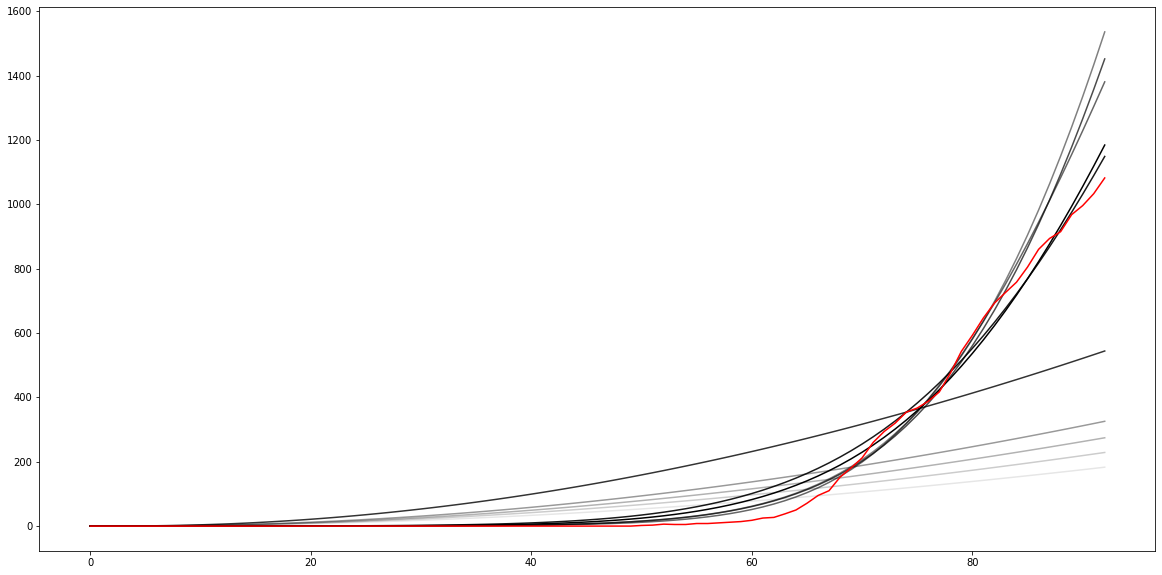

In [419]:
plt.figure(figsize=(20,10))
for ns in range(1,20,2):
    res = least_squares(death_cost, guesses, args=(xs[:-ns],), bounds=np.transpose(np.array(param_ranges+initial_ranges)))
    plt.plot(model(res.x,tmax=len(xs))[:,5],alpha=1-(ns-1)/20,c='k')
plt.plot(xs,c='r')
plt.show()

In [420]:
res.x

array([1.11704373e+00, 2.47549824e-01, 1.54274519e-03, 4.00836615e-01,
       1.51053995e-03, 8.33917487e-02, 1.89976291e-01, 9.38174639e-26,
       1.70678487e-38, 7.48696640e-03, 4.04456420e-01])

In [421]:
population = 451443
num = np.array([(1-np.sum(res.x[6:])),res.x[10],res.x[6],res.x[7],res.x[9],res.x[8],0])*population
print("Initial S: {0}\nInitial SA: {1}\nInitial E: {2}\nInitial I: {3}\nInitial R: {4}\nInitial Q: {5}\nInitial D: {6}\n".format(*list(num)))

Initial S: 179710.5748956449
Initial SA: 182589.019638874
Initial E: 85763.46689268856
Initial I: 4.2353237339698e-20
Initial R: 3379.938572792535
Initial Q: 7.705160840267714e-33
Initial D: 0.0



In [436]:
tmp=df.iloc[15,4:]
tmp[tmp>0].index[0]

'3/25/20'

In [545]:
def get_first_nonzero(s):
    tmp = np.nonzero(s.values)[1]
    if len(tmp) > 0:
        return s.columns[tmp[0]]
    else:
        return None

In [445]:
get_first_nonzero(30)

'3/22/20'

In [449]:
X.index

Int64Index([ 107,  110,  193,  211,  222,  225,  228,  229,  230,  235,
            ...
            2669, 2788, 2795, 2841, 2897, 2941, 3019, 3029, 3033, 3139],
           dtype='int64', length=121)

In [450]:
first = []
for i in X.index:
    first.append(get_first_nonzero(i))

In [463]:
nth_to_date = {i:df.columns[4+i] for i in range(93)}

In [546]:
get_first_nonzero(df[df['countyFIPS']==51153].iloc[:,4:])

'3/13/20'

In [1280]:
x_i = df[df['countyFIPS']==4019]
x_d = df2[df2['countyFIPS']==4019]

In [1281]:
x_ds = x_d.loc[:,padding_i:].values.flatten()
x_is = x_i.loc[:,padding_i:].values.flatten()

In [1293]:
df.loc[ind,'countyFIPS']

211      6037
317      9001
318      9003
321      9009
625     17031
1248    25017
1250    25021
1252    25025
1304    26099
1317    26125
1336    26163
1807    34003
1812    34013
1814    34017
1817    34023
1821    34031
1825    34039
1865    36005
1886    36047
1892    36059
1893    36061
1903    36081
1905    36085
1914    36103
1922    36119
Name: countyFIPS, dtype: int64

In [1301]:
df_pop = df_pop.set_index('FIPS')

In [1302]:
df_pop

,total_pop,60plus
FIPS,,
1001,55036,10523
1003,203360,53519
1005,26201,6150
1007,22580,4773
1009,57667,13600
...,...,...
56037,44527,7015
56039,22923,4298
56041,20758,3554


In [1337]:
def predict_selected_county(countyFIPS):
    N = df_pop.loc[countyFIPS, 'total_pop']
    x_i = df[df['countyFIPS']==countyFIPS]
    x_d = df2[df2['countyFIPS']==countyFIPS]
    padding_i = get_first_nonzero(x_i.iloc[:,4:])
    print("First case: {}".format(padding_i))
    padding_d = get_first_nonzero(x_d.iloc[:,4:])
    print("First death: {}".format(padding_d))
    x_ds = x_d.loc[:,padding_i:].values.flatten()/N
    x_is = x_i.loc[:,padding_i:].values.flatten()/N
    # print("Deaths from date of first death: {}".format(xs))
    plt.figure(figsize=(20,10))
    for ns in range(1,20,2):
        res = least_squares(death_cost, guesses,
                            args=(x_ds[:-ns],x_is[:-ns]),
                            bounds=np.transpose(np.array(param_ranges+initial_ranges))
                           )
        pred = model(res.x,tmax=len(x_is))
        plt.plot(pred[:,5]*N,alpha=1-(ns-1)/20,c='r')
        plt.plot(pred[:,2]*N,alpha=1-(ns-1)/20,c='b')
    plt.plot(x_ds*N,c='r')
    plt.plot(x_is*N,c='b')
    plt.title("Death predictions for {name}, {state}".format(name=x_i['County Name'].values[0],state=x_i['State'].values[0]))
    plt.show()

First case: 3/14/20
First death: 3/25/20


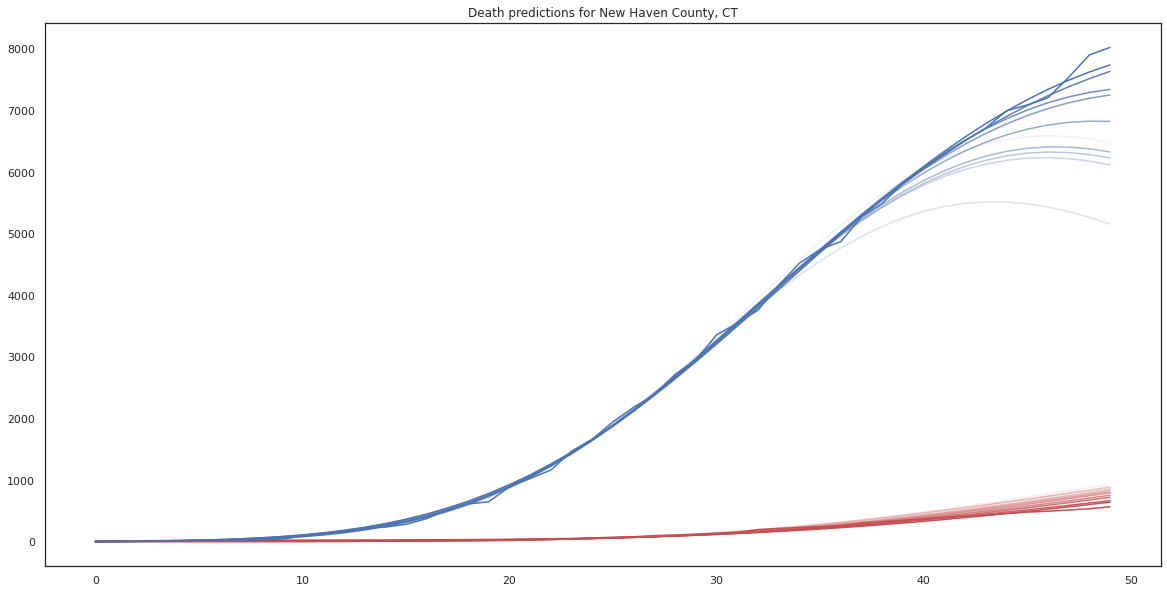

In [1338]:
predict_selected_county(9009)

First case: 3/12/20
First death: 3/29/20


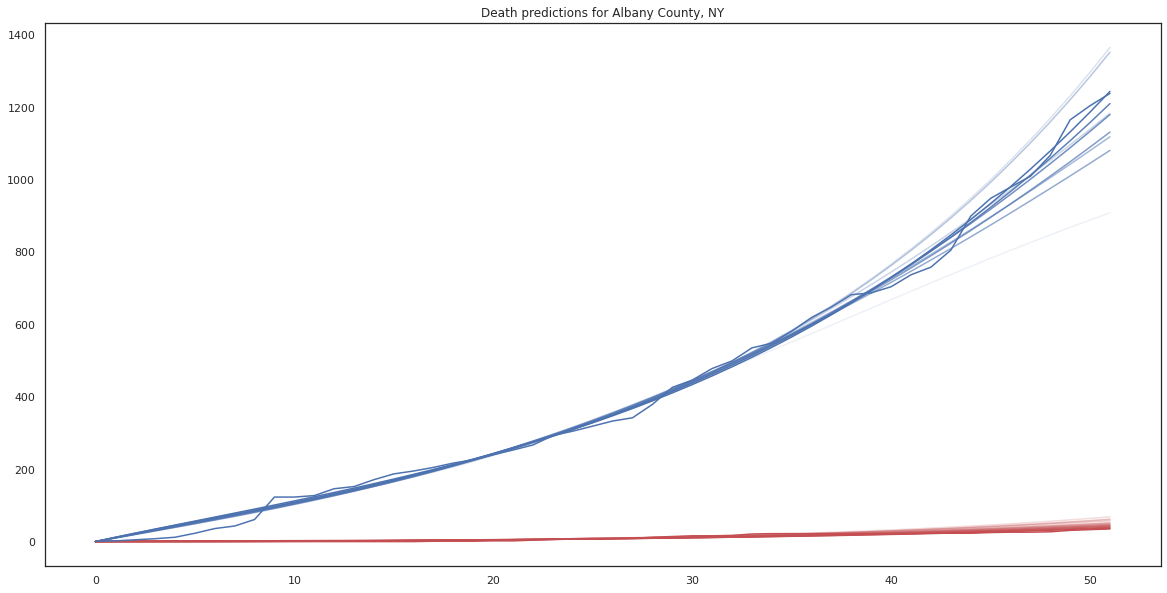

In [1479]:
predict_selected_county(36001)

In [1339]:
def predict_selected_county_before_window2(countyFIPS, n_days_before):
    N = df_pop.loc[countyFIPS, 'total_pop']
    x_i = df[df['countyFIPS']==countyFIPS]
    x_d = df2[df2['countyFIPS']==countyFIPS]
    padding_i = get_first_nonzero(x_i.iloc[:,4:])
    padding_d = get_first_nonzero(x_d.iloc[:,4:])
    x_ds = x_d.loc[:,padding_i:].values.flatten()/N
    x_is = x_i.loc[:,padding_i:].values.flatten()/N
    res = least_squares(death_cost, guesses,args=(x_ds[:-n_days_before],x_is[:-n_days_before]),bounds=np.transpose(np.array(param_ranges+initial_ranges)))
    return res

In [1217]:
def predict_selected_county_before_window2(countyFIPS, n_days_before):
    x_raw = df2[df2['countyFIPS']==countyFIPS]
    padding = get_first_nonzero(x_raw.iloc[:,4:])
    xs = x_raw.loc[:,padding:].values.flatten()
    res = least_squares(death_cost, guesses, args=(xs[:-n_days_before],), bounds=np.transpose(np.array(param_ranges+initial_ranges)))
    return res

In [1354]:
X_correlations = pd.DataFrame(index=df.loc[ind,'countyFIPS'].values)
X_correlations.head()

""
6037
9001
9003
9009
17031


In [1357]:
counter = 0
for f in X_correlations.index:
    tmp = predict_selected_county_before_window2(f, 1)
    for i in range(11):
        X_correlations.loc[f, 'param'+str(i)]=tmp.x[i]
    print(counter)
    counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [1359]:
X_correlations.index

Int64Index([ 6037,  9001,  9003,  9009, 17031, 25017, 25021, 25025, 26099,
            26125, 26163, 34003, 34013, 34017, 34023, 34031, 34039, 36005,
            36047, 36059, 36061, 36081, 36085, 36103, 36119,  1073,  1097,
             4001,  4005,  4013,  4017,  4019,  5079,  5119,  6001,  6013,
             6019,  6029,  6059,  6065,  6067,  6071,  6073,  6075,  6077,
             6081,  6083,  6085,  6107,  6111,  8001,  8005,  8013,  8031,
             8035,  8037],
           dtype='int64')

## Correlation plots

### Beds

In [600]:
df_beds = pd.read_csv(datadir + 'us/hospitals/beds_by_county.csv')

In [1360]:
X_bed_tot = pd.merge(X_correlations, df_beds, left_index=True, right_on='FIPS').drop(columns=['state','county','Name']).set_index('FIPS')

In [613]:
import seaborn as sns

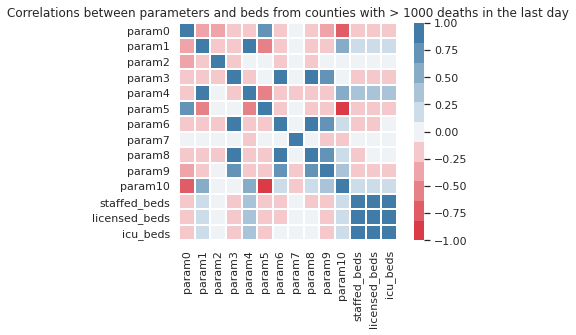

In [1361]:
sns.heatmap(X_bed_tot.corr(), vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
plt.title("Correlations between parameters and beds from counties with > 1000 deaths in the last day")
plt.savefig("corr_beds.png")

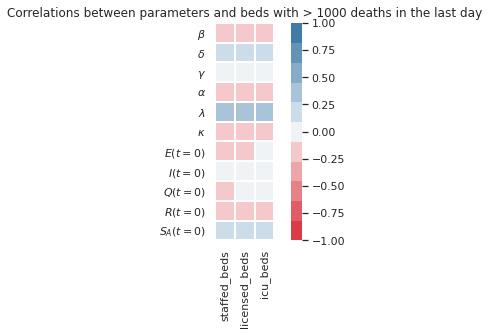

In [1484]:
#plt.figure(figsize=(30,5))
ax = sns.heatmap(X_bed_tot.corr().loc[:'param10', 'staffed_beds':], vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
locs, labels = plt.yticks()
plt.yticks(locs, [r"$\beta$",
                  r"$\delta$",
                  r"$\gamma$",
                  r"$\alpha$",
                  r"$\lambda$",
                  r"$\kappa$",
                  r"$E(t=0)$",r"$I(t=0)$",r"$Q(t=0)$",
                  r"$R(t=0)$",r"$S_A(t=0)$"]
          )
plt.title("Correlations between parameters and beds with > 1000 deaths in the last day")
plt.savefig("corr_beds.png")

### Mobility

In [621]:
df_mob = pd.read_csv(datadir + 'us/mobility/DL-us-m50.csv')

In [681]:
df_mob_ind = pd.read_csv(datadir + 'us/mobility/DL-us-m50_index.csv')
df_mob_ind.head()

,country_code,admin_level,admin1,admin2,fips,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-21
0,US,1,Alabama,NaN,1.0,79.0,98.0,100.0,96.0,104.0,...,44.0,0.0,50.0,51.0,56.0,59.0,68.0,49.0,4.0,62.0
1,US,2,Alabama,Autauga County,1001.0,49.0,100.0,95.0,95.0,100.0,...,33.0,1.0,43.0,36.0,42.0,45.0,56.0,34.0,0.0,48.0
2,US,2,Alabama,Baldwin County,1003.0,81.0,100.0,95.0,90.0,102.0,...,39.0,1.0,48.0,49.0,52.0,53.0,57.0,43.0,16.0,58.0
3,US,2,Alabama,Barbour County,1005.0,90.0,107.0,100.0,70.0,88.0,...,44.0,13.0,50.0,51.0,54.0,62.0,67.0,58.0,7.0,71.0
4,US,2,Alabama,Bibb County,1007.0,53.0,95.0,100.0,94.0,111.0,...,29.0,3.0,43.0,51.0,50.0,55.0,55.0,45.0,4.0,59.0


In [682]:
df_mob_ind['mean1']=np.mean(df_mob_ind[df_mob_ind.columns[5:15]],axis=1)
df_mob_ind['mean2']=np.mean(df_mob_ind[df_mob_ind.columns[15:25]],axis=1)
df_mob_ind['mean3']=np.mean(df_mob_ind[df_mob_ind.columns[25:35]],axis=1)
df_mob_ind['mean4']=np.mean(df_mob_ind[df_mob_ind.columns[35:45]],axis=1)

In [689]:
df_mob_ind.head()

,country_code,admin_level,admin1,admin2,fips,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,...,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-21,mean1,mean2,mean3,mean4,mean5
0,US,1,Alabama,NaN,1.0,79.0,98.0,100.0,96.0,104.0,...,59.0,68.0,49.0,4.0,62.0,99.3,87.1,48.2,43.8,43.9
1,US,2,Alabama,Autauga County,1001.0,49.0,100.0,95.0,95.0,100.0,...,45.0,56.0,34.0,0.0,48.0,89.8,74.2,37.3,34.3,33.3
2,US,2,Alabama,Baldwin County,1003.0,81.0,100.0,95.0,90.0,102.0,...,53.0,57.0,43.0,16.0,58.0,95.4,87.1,48.2,40.5,40.9
3,US,2,Alabama,Barbour County,1005.0,90.0,107.0,100.0,70.0,88.0,...,62.0,67.0,58.0,7.0,71.0,98.4,93.6,65.3,53.4,48.6
4,US,2,Alabama,Bibb County,1007.0,53.0,95.0,100.0,94.0,111.0,...,55.0,55.0,45.0,4.0,59.0,97.3,83.7,37.9,37.5,39.0


In [688]:
df_mob_ind['mean5']=np.mean(df_mob_ind[df_mob_ind.columns[45:-6]],axis=1)

In [642]:
df_mob['fips'].dropna().astype(int)

0           1
1        1001
2        1003
3        1005
4        1007
        ...  
2717    56033
2718    56035
2719    56037
2720    56039
2721    56041
Name: fips, Length: 2721, dtype: int64

In [690]:
df_mob_ind=df_mob_ind.dropna(subset=['fips'])

In [691]:
df_mob_ind['FIPS'] = df_mob_ind['fips'].dropna().astype(int)

<ipython-input-691-b053b68cdcdf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mob_ind['FIPS'] = df_mob_ind['fips'].dropna().astype(int)


In [692]:
df_mob_ind

,country_code,admin_level,admin1,admin2,fips,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,...,2020-04-17,2020-04-18,2020-04-19,2020-04-21,mean1,mean2,mean3,mean4,mean5,FIPS
0,US,1,Alabama,NaN,1.0,79.0,98.0,100.0,96.0,104.0,...,68.0,49.0,4.0,62.0,99.3,87.1,48.200,43.8,43.9,1
1,US,2,Alabama,Autauga County,1001.0,49.0,100.0,95.0,95.0,100.0,...,56.0,34.0,0.0,48.0,89.8,74.2,37.300,34.3,33.3,1001
2,US,2,Alabama,Baldwin County,1003.0,81.0,100.0,95.0,90.0,102.0,...,57.0,43.0,16.0,58.0,95.4,87.1,48.200,40.5,40.9,1003
3,US,2,Alabama,Barbour County,1005.0,90.0,107.0,100.0,70.0,88.0,...,67.0,58.0,7.0,71.0,98.4,93.6,65.300,53.4,48.6,1005
4,US,2,Alabama,Bibb County,1007.0,53.0,95.0,100.0,94.0,111.0,...,55.0,45.0,4.0,59.0,97.3,83.7,37.900,37.5,39.0,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,US,2,Wyoming,Sheridan County,56033.0,61.0,89.0,95.0,100.0,109.0,...,75.0,71.0,4.0,74.0,90.7,79.3,50.800,52.0,46.3,56033
2718,US,2,Wyoming,Sublette County,56035.0,21.0,89.0,90.0,99.0,165.0,...,45.0,19.0,14.0,40.0,103.3,115.5,21.375,16.5,26.9,56035
2719,US,2,Wyoming,Sweetwater County,56037.0,51.0,88.0,97.0,100.0,136.0,...,102.0,79.0,44.0,92.0,103.9,116.6,80.700,83.6,67.7,56037
2720,US,2,Wyoming,Teton County,56039.0,140.0,101.0,95.0,100.0,95.0,...,38.0,35.0,14.0,31.0,115.5,83.6,17.800,13.3,18.5,56039


In [693]:
df_mob_ind2=pd.DataFrame(df_mob_ind[['FIPS', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5']])

In [1363]:
X_mobind_tot=pd.merge(df_mob2, X_correlations,left_on='FIPS', right_index=True).set_index('FIPS')

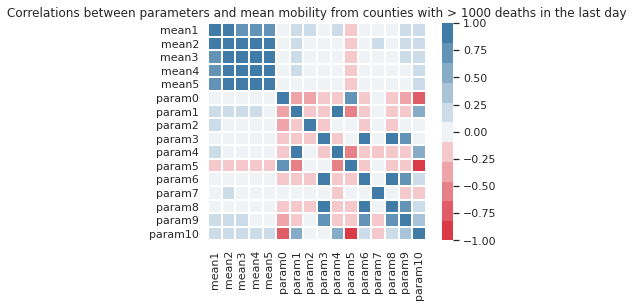

In [1364]:
sns.heatmap(X_mobind_tot.corr(), vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
plt.title("Correlations between parameters and mean mobility from counties with > 1000 deaths in the last day")
plt.savefig("corr_mob.png")

In [1365]:
X_mobind_tot=pd.merge(df_mob_ind2, X_correlations,left_on='FIPS', right_index=True).set_index('FIPS')

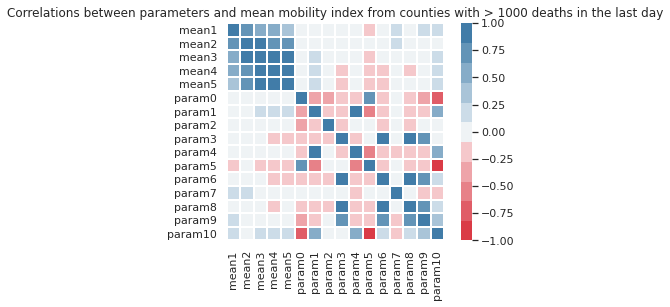

In [1366]:
sns.heatmap(X_mobind_tot.corr(), vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)

plt.title("Correlations between parameters and mean mobility index from counties with > 1000 deaths in the last day")
plt.savefig("corr_mob.png")

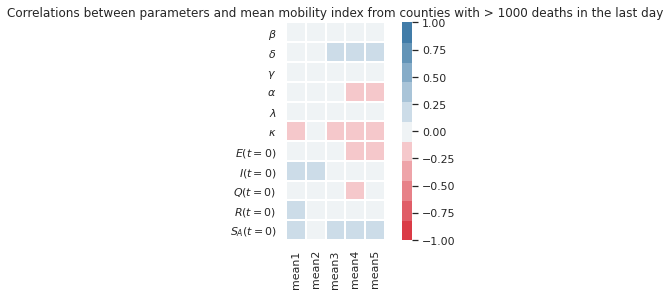

In [1367]:
sns.heatmap(X_mobind_tot.corr().loc['param0':, :'mean5'], vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
locs, labels = plt.yticks()
plt.yticks(locs, [r"$\beta$",
                  r"$\delta$",
                  r"$\gamma$",
                  r"$\alpha$",
                  r"$\lambda$",
                  r"$\kappa$",
                  r"$E(t=0)$",r"$I(t=0)$",r"$Q(t=0)$",
                  r"$R(t=0)$",r"$S_A(t=0)$"]
          )
plt.title("Correlations between parameters and mean mobility index from counties with > 1000 deaths in the last day")
plt.savefig("corr_mob.png")

In [735]:
df_mob_ind.columns[-7]

'2020-04-21'

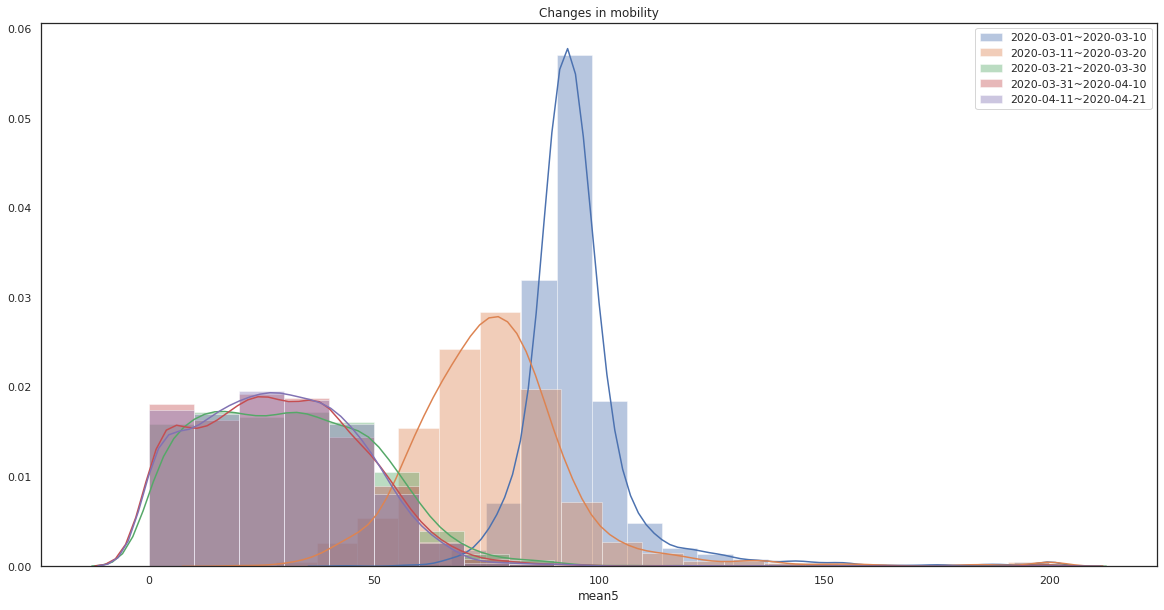

In [987]:
plt.figure(figsize=(20,10))
sns.distplot(np.clip(df_mob_ind2['mean1'],0,200),bins=20)
sns.distplot(np.clip(df_mob_ind2['mean2'],0,200),bins=20)
sns.distplot(np.clip(df_mob_ind2['mean3'],0,200),bins=20)
sns.distplot(np.clip(df_mob_ind2['mean4'],0,200),bins=20)
sns.distplot(np.clip(df_mob_ind2['mean5'],0,200),bins=20)
plt.legend(('2020-03-01'+'~'+'2020-03-10','2020-03-11'+'~'+'2020-03-20','2020-03-21'+'~'+'2020-03-30','2020-03-31'+'~'+'2020-04-10','2020-04-11'+'~'+'2020-04-21'))
plt.title('Changes in mobility')
plt.savefig('mobility_changes.png')

### Berkeley Aggregate

In [747]:
df_berkeley = pd.read_csv(datadir + 'us/aggregate_berkeley.csv').set_index('Unnamed: 0').reset_index(drop=True)
df_berkeley.head()

,countyFIPS,State,County,PopulationEstimate2018,Population(Persons)2017,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,...,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated
0,1001,Alabama,Autauga,55601.0,55504.0,27007.0,28497.0,0.486578,8392.0,91.8,...,0.0,0.0,10.0,20.0,44.0,73.0,112.0,143.0,109.0,33.194755
1,1003,Alabama,Baldwin,218022.0,212628.0,103225.0,109403.0,0.485472,42413.0,114.7,...,0.0,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,148.887537
2,1005,Alabama,Barbour,24881.0,25270.0,13335.0,11935.0,0.527701,4757.0,31.0,...,0.0,0.0,0.0,0.0,21.0,44.0,65.0,72.0,68.0,18.483155
3,1007,Alabama,Bibb,22400.0,22668.0,12138.0,10530.0,0.535469,3632.0,36.8,...,0.0,0.0,0.0,0.0,24.0,37.0,62.0,56.0,45.0,15.381366
4,1009,Alabama,Blount,57840.0,58013.0,28607.0,29406.0,0.493114,10351.0,88.9,...,0.0,10.0,13.0,25.0,49.0,94.0,150.0,182.0,142.0,48.499442


In [765]:
df_berkeley.columns

Index(['countyFIPS', 'State', 'County', 'PopulationEstimate2018',
       'Population(Persons)2017', 'PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017', 'PopulationEstimate65+2017',
       'PopulationDensityperSqMile2010', 'CensusPopulation2010',
       'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010',
       '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017',
       '3-YrDiabetes2015-17', 'DiabetesPercentage', 'HeartDiseaseMortality',
       'StrokeMortality', 'Smokers_Percentage', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-4420

In [767]:
for keys in ['PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
       'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
       'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
       'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
       'PopMale>842010', 'PopFmle>842010']:
    df_berkeley[keys] = df_berkeley[keys]/df_berkeley['PopulationEstimate2018']

In [771]:
for keys in ['3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',
       'mortality2015-17Estimated']:
    df_berkeley[keys] = df_berkeley[keys]/df_berkeley['Population(Persons)2017']

In [1369]:
X_berkeley_tot = pd.merge(X_correlations, df_berkeley, left_index=True, right_on='countyFIPS').drop(columns=['State', 'County']).set_index('countyFIPS')

0. $\beta\quad(S\times I\to E)$
1. $\delta\quad(Q\to R)$
2. $\gamma\quad(E\to I)$
3. $\alpha\quad(S\to S_A)$
4. $\lambda\quad(I\to Q)$
5. $\kappa\quad(Q\to D)$
6. $E(t=0)$
7. $I(t=0)$
8. $Q(t=0)$
9. $R(t=0)$
10. $S_A(t=0)$


In [871]:
cmap = sns.diverging_palette(10,
                             240,
                             #as_cmap=True,
                             n=11,
                             sep=1)

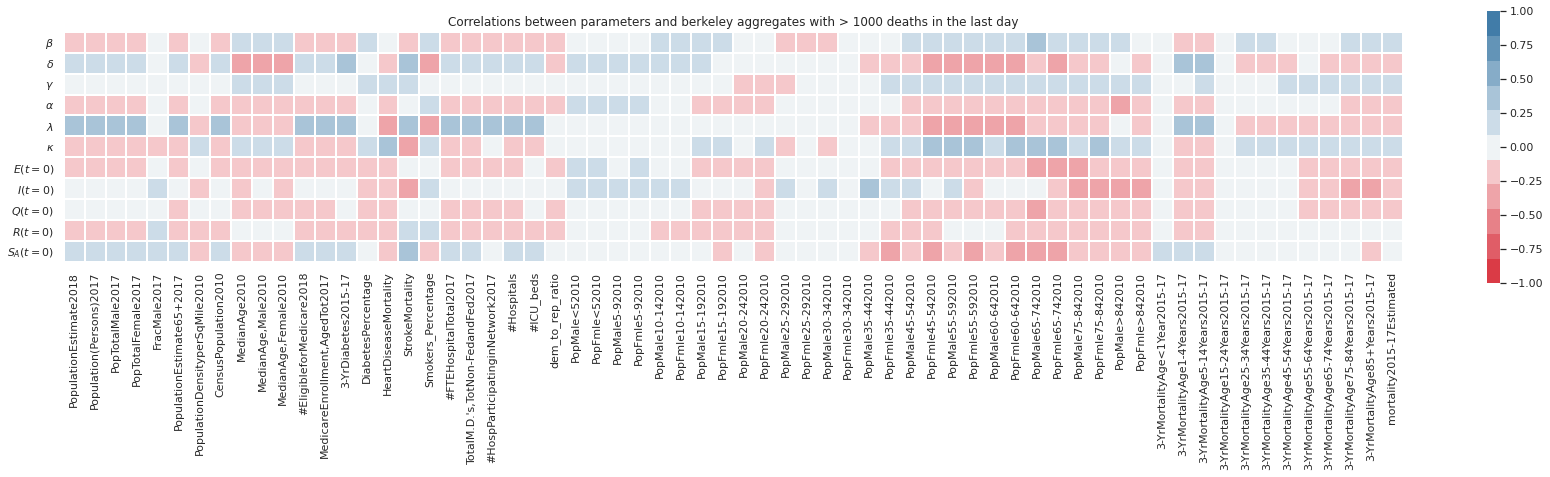

In [1483]:
plt.figure(figsize=(30,5))
ax = sns.heatmap(X_berkeley_tot.corr().loc[:'param10', 'PopulationEstimate2018':], vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
locs, labels = plt.yticks()
plt.yticks(locs, [r"$\beta$",
                  r"$\delta$",
                  r"$\gamma$",
                  r"$\alpha$",
                  r"$\lambda$",
                  r"$\kappa$",
                  r"$E(t=0)$",r"$I(t=0)$",r"$Q(t=0)$",
                  r"$R(t=0)$",r"$S_A(t=0)$"]
          )
plt.title("Correlations between parameters and berkeley aggregates with > 1000 deaths in the last day")
plt.savefig("corr_berkeley_zoomin_discrete.png")

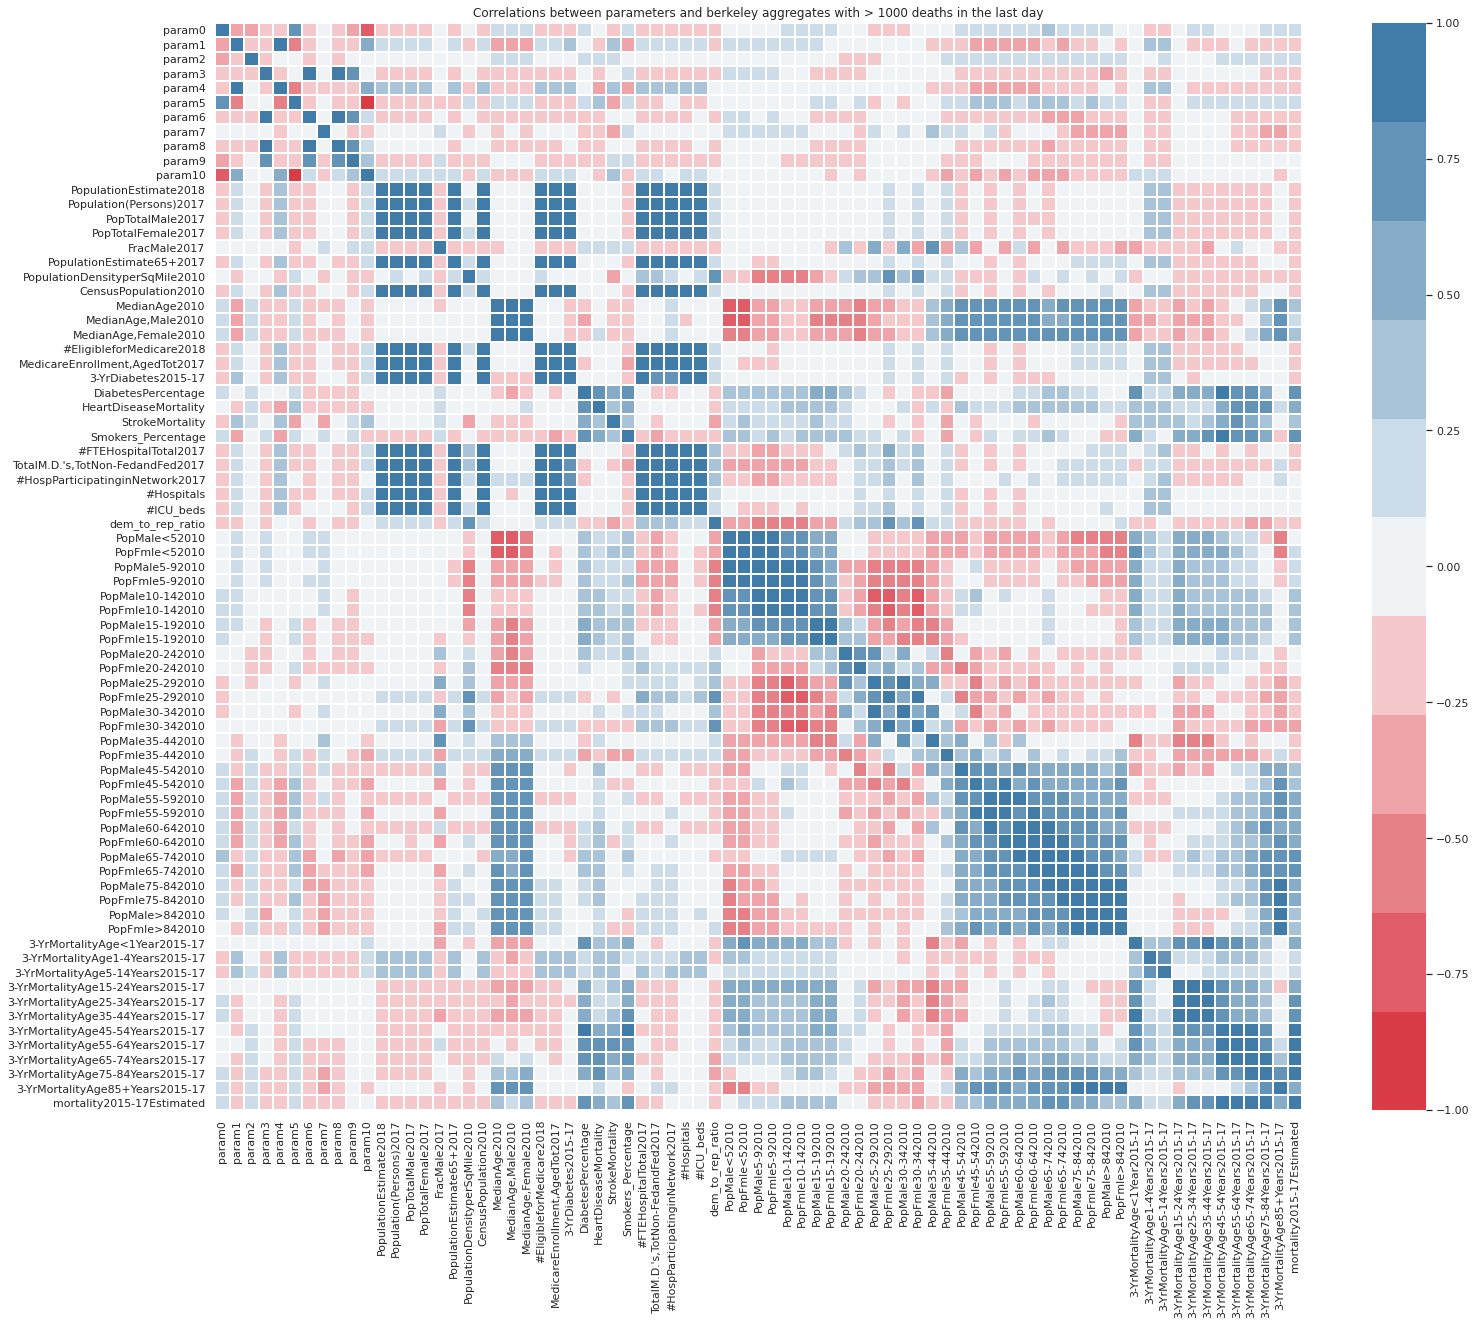

In [1371]:
plt.figure(figsize=(25,20))
sns.heatmap(X_berkeley_tot.corr(), vmin=-1, vmax=1,cmap=cmap, linewidths=1, square=True)
plt.title("Correlations between parameters and berkeley aggregates with > 1000 deaths in the last day")
plt.savefig("corr_berkeley.png")

# Regression on SEIR parameters

## Model exploration

In [1037]:
from sklearn.inspection import permutation_importance

In [1030]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge

In [1458]:
X_berkeley_tot

,param0,param1,param2,param3,param4,param5,param6,param7,param8,param9,...,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated
countyFIPS,,,,,,,,,,,,,,,,,,,,,
6037,1.776568,2.044651e+00,0.092898,0.000294,6.291537e-01,0.017906,4.352523e-04,1.123804e-05,6.598899e-05,6.452789e-03,...,0.000011,0.000075,0.000124,0.000179,0.000406,0.000814,0.001065,0.001384,0.002095,0.000345
9001,2.595662,7.467698e-01,0.069194,0.094077,7.548567e-03,0.958503,9.980869e-05,5.217307e-12,3.204494e-05,1.609851e-05,...,0.000000,0.000066,0.000119,0.000149,0.000350,0.000698,0.001030,0.001640,0.003134,0.000398
9003,1.708638,3.585705e-01,0.176847,0.065013,2.604899e-02,0.220591,2.533357e-05,1.101118e-10,2.585792e-05,2.578213e-06,...,0.000000,0.000074,0.000159,0.000210,0.000515,0.000956,0.001397,0.001979,0.003659,0.000550
9009,2.749195,3.097877e-01,0.124814,0.082982,2.288050e-02,0.094378,3.017724e-05,5.281194e-13,1.132121e-04,1.697866e-05,...,0.000014,0.000077,0.000163,0.000212,0.000489,0.001062,0.001468,0.001951,0.003644,0.000559
17031,1.174203,8.273785e-01,0.284457,0.002279,4.133777e-01,0.005164,2.405182e-08,3.186728e-06,3.563101e-03,3.814638e-05,...,0.000014,0.000127,0.000179,0.000231,0.000505,0.001098,0.001393,0.001736,0.002455,0.000475
25017,1.489469,1.002996e-01,0.342335,0.043970,1.849674e-02,0.048455,6.210875e-06,2.100383e-06,2.760442e-06,1.756909e-01,...,0.000009,0.000062,0.000139,0.000162,0.000367,0.000718,0.001079,0.001695,0.002938,0.000403
25021,1.224335,7.769042e-02,0.399274,0.045910,1.519592e-02,0.080784,8.803271e-07,2.573983e-06,1.575557e-12,1.534288e-01,...,0.000000,0.000067,0.000151,0.000158,0.000377,0.000814,0.001278,0.001961,0.003583,0.000490
25025,2.211901,1.101988e+00,0.109439,0.000069,6.831636e-01,0.008356,4.948827e-05,1.616561e-09,5.189168e-04,1.055678e-02,...,0.000000,0.000075,0.000174,0.000216,0.000417,0.000802,0.001036,0.001301,0.001974,0.000337
26099,5.360090,7.112789e-02,0.070625,0.152997,6.117037e-03,1.586727,5.106334e-05,1.315170e-12,3.195446e-05,2.418972e-05,...,0.000015,0.000107,0.000202,0.000251,0.000627,0.001261,0.001852,0.002293,0.003369,0.000654


In [1464]:
rf_Y = X_berkeley_tot.loc[:,'param1'].reset_index(drop=True)
rf_X = X_berkeley_tot.loc[:,['Smokers_Percentage','MedianAge2010']].reset_index(drop=True)

In [1465]:
# rf_Y = df.loc[rf_X.index,'5/2/20']

In [1470]:
from sklearn.model_selection import KFold
def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = LinearRegression()
    for train, test in cv.split(rf_X, rf_Y):
        cv_clf.fit(rf_X.iloc[train], rf_Y.iloc[train])
        print(cv_clf.score(rf_X.iloc[test], rf_Y.iloc[test]))
    return None

In [1471]:
cv_estimate(10)

0.2743910336884898
0.33898215732051673
-9.531451871054959
-6.7980133473016195
-0.38580434753302906
-0.4381988038381968
-0.4826470489455497
-0.3657809794595843
-0.12260244852448587
-3.7280020004150782


## Hyperparameter tuning

In [1426]:
from sklearn.model_selection import GridSearchCV

In [1427]:
clf = GridSearchCV(rfc, {'max_depth': [10, 20], 'min_impurity_decrease': [0.05, 0.1]})
clf.fit(rf_X,rf_Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [1428]:
clf.cv_results_

{'mean_fit_time': array([0.08476663, 0.0807559 , 0.08542843, 0.08089156]),
 'std_fit_time': array([0.00167596, 0.00233178, 0.00260561, 0.00184065]),
 'mean_score_time': array([0.00380812, 0.00378771, 0.00385551, 0.00377712]),
 'std_score_time': array([6.96338349e-05, 8.65615615e-05, 6.83461529e-05, 4.11404644e-05]),
 'param_max_depth': masked_array(data=[10, 10, 20, 20],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_impurity_decrease': masked_array(data=[0.05, 0.1, 0.05, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'min_impurity_decrease': 0.05},
  {'max_depth': 10, 'min_impurity_decrease': 0.1},
  {'max_depth': 20, 'min_impurity_decrease': 0.05},
  {'max_depth': 20, 'min_impurity_decrease': 0.1}],
 'split0_test_score': array([-1.22348183, -1.14646161, -0.95728901, -0.7699071 ]),
 'split1_test_score': array([ -9.43386946, -10.746

## Permutation importance

In [1473]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rf_X, rf_Y, test_size=0.33, random_state=42)

In [1474]:
reg = LinearRegression()
reg.fit(X_train,y_train)
result = permutation_importance(reg, X_test, y_test, random_state=10, n_repeats=15, n_jobs=8)

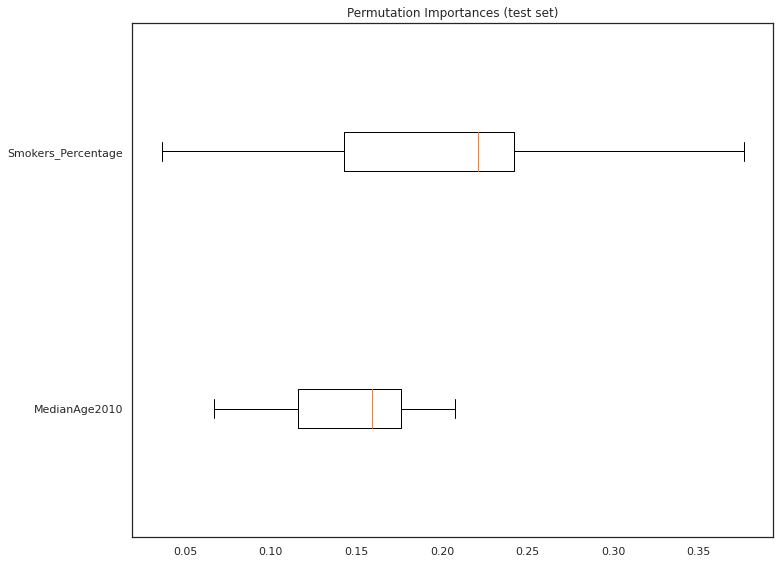

In [1475]:
sorted_idx = result.importances_mean.argsort()[:10]
fig, ax = plt.subplots()
fig.set_size_inches(11,8)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Partial dependency plot

In [1476]:
from sklearn.inspection import plot_partial_dependence

In [1416]:
X_berkeley_tot.columns

Index(['param0', 'param1', 'param2', 'param3', 'param4', 'param5', 'param6',
       'param7', 'param8', 'param9', 'param10', 'PopulationEstimate2018',
       'Population(Persons)2017', 'PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017', 'PopulationEstimate65+2017',
       'PopulationDensityperSqMile2010', 'CensusPopulation2010',
       'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010',
       '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017',
       '3-YrDiabetes2015-17', 'DiabetesPercentage', 'HeartDiseaseMortality',
       'StrokeMortality', 'Smokers_Percentage', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
    

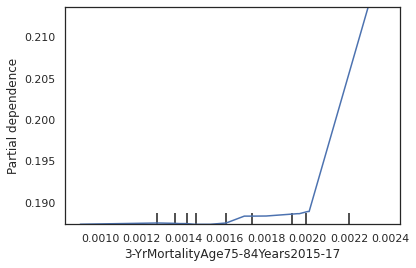

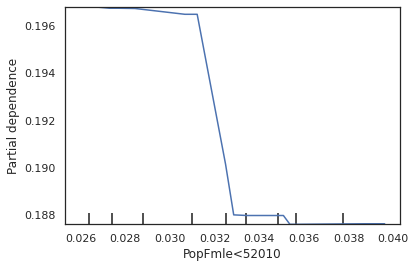

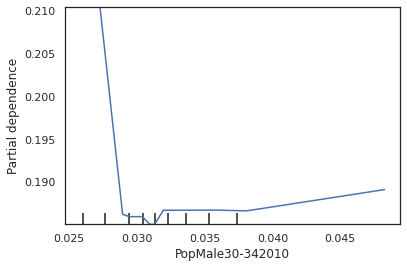

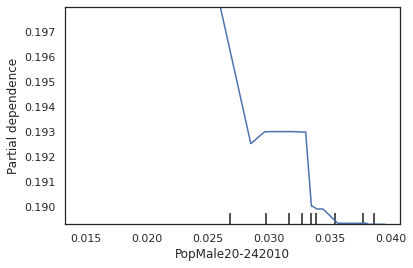

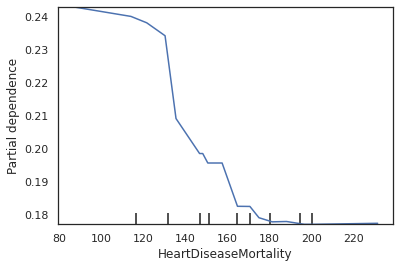

In [1417]:
plot_partial_dependence(reg, X_test, [sorted_idx[0]])
plot_partial_dependence(reg, X_test, [sorted_idx[1]])
plot_partial_dependence(reg, X_test, [sorted_idx[2]])
plot_partial_dependence(reg, X_test, [sorted_idx[3]])
plot_partial_dependence(reg, X_test, [sorted_idx[4]])

/home/tzuchen/PycharmProjects/SKTW/venv/lib64/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:713: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  warnings.warn("The fig parameter is deprecated in version "


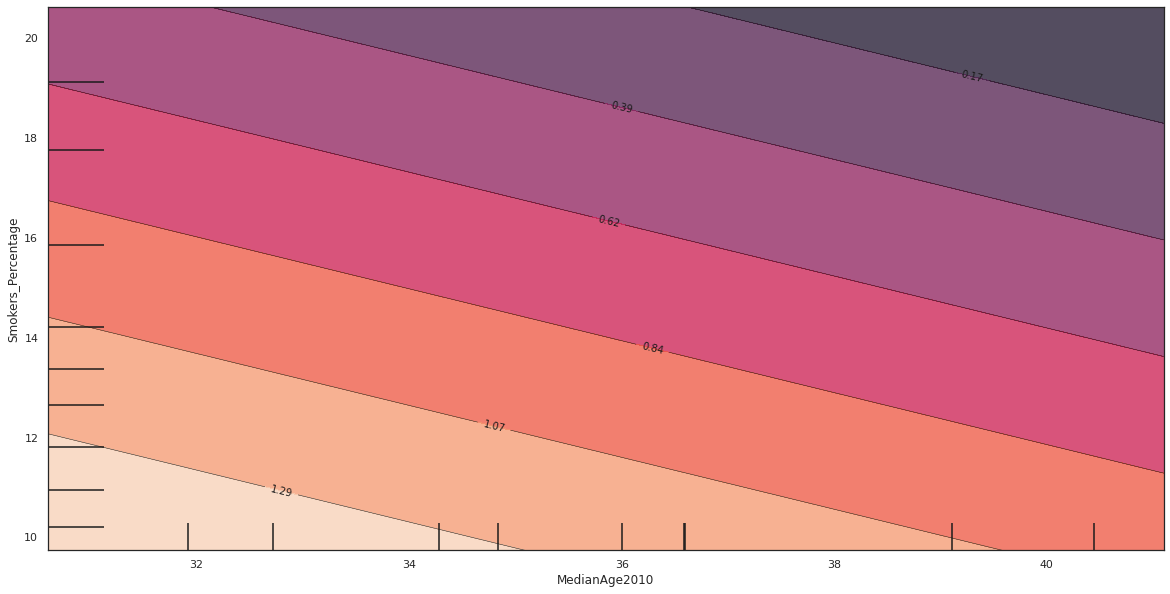

In [1477]:
fig = plt.figure(figsize=(20,10))
plot_partial_dependence(reg, X_test,[(sorted_idx[0],sorted_idx[1])], fig=fig, grid_resolution=1000)
plt.show()

## SHAP